In [1]:
#Library Import
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot as plt

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression,Lasso,Ridge
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA s
pd.set_option('display.max_rows', 500)

# Data Cleaning

In [2]:
# Data Import from official website
player_stats = pd.read_csv('../Datasets/nba_player_stats_official.csv')

# Average score for each player collected from espn
player_physical = pd.read_csv('../Datasets/data_player.csv')

In [22]:
player_att = player_physical[['name','position','height','weight']]

In [23]:
# Merge with NBA official data over the years 
df = pd.merge(player_att,player_stats,how = 'left', left_on=['name'], right_on = ['PLAYER_NAME']).drop(columns = ['PLAYER_NAME']).dropna()

# EDA -  Physical Attribute and Performance

## ESPN Players Physical Attribute - Height, Weight, Age

In [24]:
# Individual Physical Attributes
physical_att = player_physical[['name','position','age','height','weight','GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']].dropna()

In [157]:
physical_att['age'].describe()

count    503.000000
mean      26.312127
std        4.099848
min       19.000000
25%       23.000000
50%       26.000000
75%       29.000000
max       40.000000
Name: age, dtype: float64

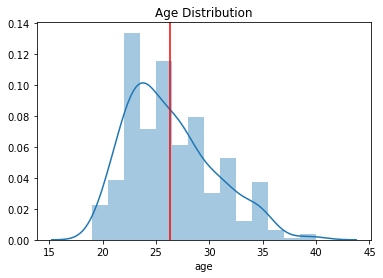

In [158]:
sns.distplot(physical_att['age'])
plt.title('Age Distribution')
plt.axvline(x=26.31,color='r')

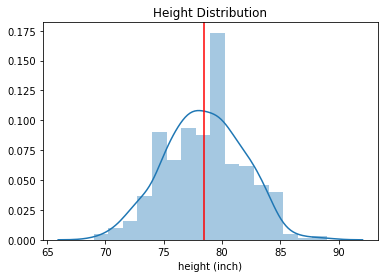

In [156]:
sns.distplot(physical_att['height'])
plt.title('Height Distribution')
plt.xlabel('height (inch)')
plt.axvline(x=78.45,color='r')

In [8]:
physical_att.height.describe()

count    503.000000
mean      78.447316
std        3.337089
min       69.000000
25%       76.000000
50%       78.000000
75%       81.000000
max       89.000000
Name: height, dtype: float64

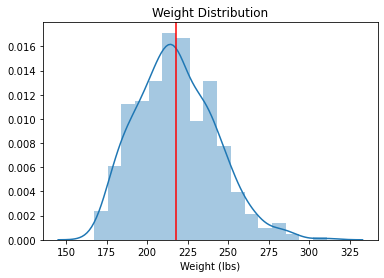

In [155]:
sns.distplot(physical_att['weight'])
plt.title('Weight Distribution')
plt.xlabel('Weight (lbs)')
plt.axvline(x=217.7,color='r')

In [10]:
physical_att.weight.describe()

count    503.000000
mean     217.773360
std       24.066068
min      167.000000
25%      200.000000
50%      215.000000
75%      235.000000
max      311.000000
Name: weight, dtype: float64

# Feature of Importance - Height and Weight

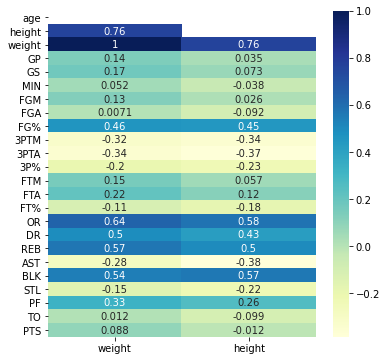

In [83]:
fig, ax = plt.subplots(figsize=(6, 6)) 
mask = np.zeros_like(physical_att.corr()[['weight','height']])
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(physical_att.corr()[['weight','height']], mask= mask, ax= ax, annot= True,cmap="YlGnBu")

## Model Fitting - Linear Regression

In [72]:
# Preparing X and y values for model fitting
X = physical_att[['height','weight']]
y = physical_att[['GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 2)

In [74]:
# Normalize the data
# mean value of the training set height and weight
m = X_train.mean()
y_m = y_train.mean()
# standard deviation of height and weight
s = X_train.std()
y_s = y_train.std()
# Normalize the training set and test set
X_train = (X_train - m) / s
X_test = (X_test - m) / s
y_train = (y_train - y_m) / y_s
y_test = (y_test - y_m) / y_s

In [162]:
# Fit linear regression models using each performance score as target variable and
#  height and weight as input variables.  
mse_test = []
mse_train =[]
perf = ['GP','GS', 'MIN', 'FGM',
       'FGA', 'FG%', '3PTM', '3PTA', '3P%', 'FTM', 'FTA', 'FT%', 'OR', 'DR',
       'REB', 'AST', 'BLK', 'STL', 'PF', 'TO', 'PTS']
for target in perf:
    X_const = sm.add_constant(X_train)
    model = sm.OLS(y_train[target], X_train)
    res = model.fit()
    #print('\nResult Summary {0}:'.format(target))
    #_ = print(res.summary2())
    #Evaluation in the test set
    pred = res.predict(X_test)
    # Records the Test error
    mse_test.append(mean_squared_error(y_test[target], pred))
    pred = res.predict(X_train)
    # Records the Test error
    mse_train.append(mean_squared_error(y_train[target], pred))

In [163]:
# Combine Performance of each model on training set and test set
pd.DataFrame({'target':perf,'score':mse_test,'train_score':mse_train})

,target,score,train_score
0,GP,0.833815,0.972458
1,GS,0.921709,0.955534
2,MIN,0.979332,0.970664
3,FGM,1.113844,0.950789
4,FGA,1.115633,0.961270
5,FG%,0.646415,0.794663
6,3PTM,0.919525,0.856812
7,3PTA,0.902769,0.837641
8,3P%,0.886811,0.940337
9,FTM,1.159416,0.955788


## Model Detail - REB, BLK,OR
Rebounds which consist of offensive rebounds and defensive rebound, blocks have the best performance.

In [80]:
# Model Details
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train['REB'], X_train)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())


Result Summary PTS:
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.344   
Dependent Variable:     REB              AIC:                         912.0311
Date:                   2020-12-07 15:31 BIC:                         919.8956
No. Observations:       377              Log-Likelihood:              -454.02 
Df Model:               2                F-statistic:                 99.77   
Df Residuals:           375              Prob (F-statistic):          1.81e-35
R-squared (uncentered): 0.347            Scale:                       0.65443 
-----------------------------------------------------------------------------------
               Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
-----------------------------------------------------------------------------------
height         0.1343        0.0653      2.0577      0.0403      0.0060      0.2627
weight         0.4797        0.0653

In [81]:
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train['BLK'], X_train)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())


Result Summary PTS:
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.351   
Dependent Variable:     BLK              AIC:                         908.0003
Date:                   2020-12-07 15:31 BIC:                         915.8648
No. Observations:       377              Log-Likelihood:              -452.00 
Df Model:               2                F-statistic:                 102.9   
Df Residuals:           375              Prob (F-statistic):          2.44e-36
R-squared (uncentered): 0.354            Scale:                       0.64747 
-----------------------------------------------------------------------------------
               Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
-----------------------------------------------------------------------------------
height         0.3534        0.0649      5.4433      0.0000      0.2258      0.4811
weight         0.2788        0.0649

In [82]:
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train['OR'], X_train)
res = model.fit()
print('\nResult Summary {0}:'.format(target))
_ = print(res.summary2())


Result Summary PTS:
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.447   
Dependent Variable:     OR               AIC:                         847.7860
Date:                   2020-12-07 15:31 BIC:                         855.6505
No. Observations:       377              Log-Likelihood:              -421.89 
Df Model:               2                F-statistic:                 153.1   
Df Residuals:           375              Prob (F-statistic):          2.41e-49
R-squared (uncentered): 0.450            Scale:                       0.55189 
-----------------------------------------------------------------------------------
               Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
-----------------------------------------------------------------------------------
height         0.2344        0.0599      3.9097      0.0001      0.1165      0.3523
weight         0.4733        0.0599

OR (Offensive rebounds per game) - R square is 0.45

REB - (rebounds per game) - R square 0.347 

BLK (Block per Game) - R square 0.354

The coefficiency are positive, which means that the higher the height and heavier the weight is, players tend to have better performance on rebounds and blocks. If the player is higher, they would more likely to reach the ball in the air first. 

# NBA - How does age affect the performance?

In [87]:
player_record = player_stats.groupby(['PLAYER_NAME']).count()['AGE'].reset_index()
player_record.rename(columns={'AGE':'Exp'}, inplace=True)

With 1359 players in total, current years of experience listed. 

Text(0.5, 1.0, 'Experience Distribution')

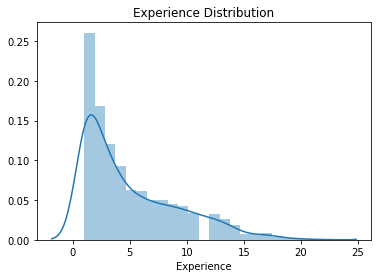

In [88]:
sns.distplot(player_record['Exp'])
plt.xlabel('Experience')
plt.title('Experience Distribution')

Players who played more than 10 years. How does the performance changes over time? 

In [105]:
# Player played more than 10 years using the official data
exp = 10
player_10 = player_record[player_record['Exp'] >= exp]
player_10 = pd.merge(player_10,player_stats,how = 'left', left_on=['PLAYER_NAME'], right_on = ['PLAYER_NAME']).dropna()

In [106]:
# (df.PTS + df.REB + df.AST + df.BLK + df.STL - (df.FGA - df.FGM) - (df.FTA - df.FTM) - df.TOV ) /GP
# NBA efficiency rating
# Reference Link: https://en.wikipedia.org/wiki/Basketball_statistics
# Data collected in already in per game format. Thus, the calculation does not divide Game played. 
def player_efficiency(df):
    return (df.PTS + df.REB + df.AST + df.BLK + df.STL - (df.FGA - df.FGM) - (df.FTA -df.FTM) - df.TOV) 

In [107]:
player_10['EFF'] = player_efficiency(player_10)

In [108]:
# Extract the first 10 records of each player played with more than 10 NBA games
player_10 = player_10.groupby(['PLAYER_NAME']).head(exp).reset_index(drop=True)

In [164]:
# Calculate the mean and median for Efficiency
med = []
avg = []
MIN_avg = [] 
for r in range(10):
    med.append(player_10[player_10['EFF'].T.index % 10 == r]['EFF'].T.describe()[5])
    avg.append(player_10[player_10['EFF'].T.index % 10 == r]['EFF'].T.describe()[1])
    MIN_avg.append(player_10[player_10['MIN'].T.index % 10 == r]['EFF'].T.describe()[1])

Text(0.5, 1.0, 'Average Efficiency')

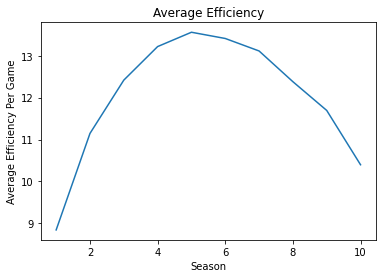

In [165]:
# Plot the average of the Effciency of the 376 players. For the past 10 years,
#   we can see that player's NBA's efficiency rating is decreasing. 
plt.plot(range(1,11,1),avg)
plt.xlabel('Season')
plt.ylabel('Average Efficiency Per Game')
plt.title('Average Efficiency')

Text(0.5, 1.0, 'Median Efficiency')

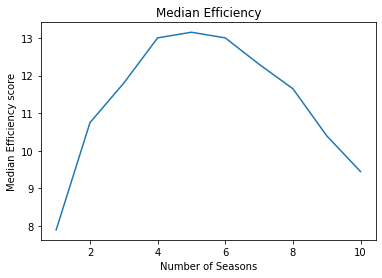

In [166]:
# Plot the median of the Effciency of the 376 players. For the past 10 years,
#   we can see that player's NBA's efficiency rating is decreasing. 
plt.plot(range(1,11,1),med)
plt.xlabel('Number of Seasons')
plt.ylabel('Median Efficiency score')
plt.title('Median Efficiency')

Text(0.5, 1.0, 'Minute Played')

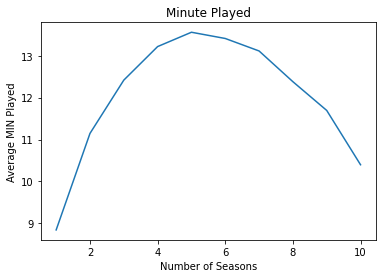

In [167]:
plt.plot(range(1,11,1),MIN_avg)
plt.xlabel('Number of Seasons')
plt.ylabel('Average MIN Played')
plt.title('Minute Played')

As we can see that that as the number of seasons played for players, they get more experience and player's efficiency will increase and peak at the fifth season. However, one of the shortage of the NBA efficiency rating is that the calculation measured heavily on the offensive performance. This measure is tied with minutes played. As the player played more, player gets more opportunities to score and potentially increase the efficiency rating. Thus, players may get under-rated 

Adjusting the rating based on the MIN played during the game

In [113]:
player_10['Adj_EFF'] = player_10['EFF'] / player_10['MIN']

In [114]:
med_adj = []
avg_adj = []
feature = 'Adj_EFF'
for r in range(10):
    med_adj.append(player_10[player_10[feature].index % 10 == r][feature].describe()[5])
    avg_adj.append(player_10[player_10[feature].index % 10 == r][feature].describe()[1])

Text(0.5, 1.0, 'Efficiency Per Minute')

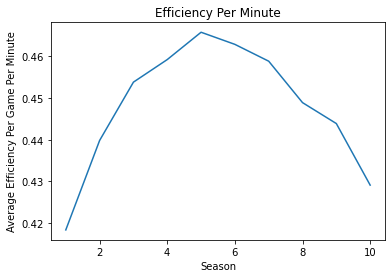

In [147]:
plt.plot(range(1,11,1),avg_adj)
plt.xlabel('Season')
plt.ylabel('Average Efficiency Per Game Per Minute')
plt.title('Efficiency Per Minute')

Weighted efficiency score is adjusted by MIN. Thus, in general, the players' efficiency will decrease after fourth season. 

Defensive Player Features:

**DREB**, **STL**, **BLK**

## Steal changes over the year

Text(0, 0.5, 'Steal Per Game')

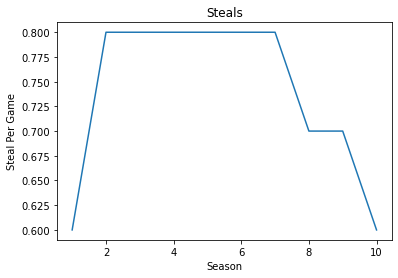

In [148]:
med_pts = []
avg_pts = []
feature = 'STL'
for r in range(10):
    med_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.title('Steals')
plt.xlabel('Season')
plt.ylabel('Steal Per Game')

## Block

Text(0, 0.5, 'Block Per Game')

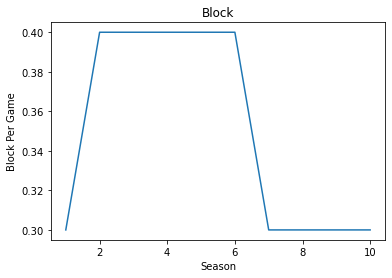

In [149]:
med_pts = []
avg_pts = []
feature = 'BLK'
for r in range(10):
    med_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.title('Block')
plt.xlabel('Season')
plt.ylabel('Block Per Game')

The data shows that after six years, the ability of block and rebounds decreases rapidly. This may due to the longer response time of the player as the age grows. 

Text(0.5, 1.0, 'Defensive Rebounds')

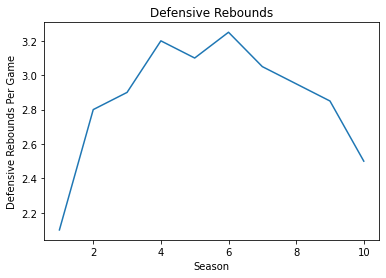

In [186]:
med_pts = []
avg_pts = []
feature = 'DREB'
for r in range(10):
    med_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].T.index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.xlabel('Season')
plt.ylabel('Defensive Rebounds Per Game')
plt.title('Defensive Rebounds')

Text(0.5, 1.0, 'Personal Fouls')

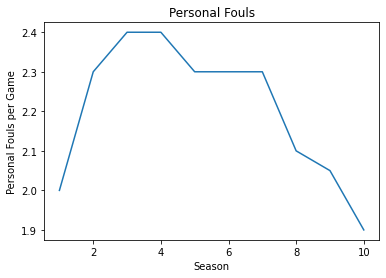

In [266]:
med_pts = []
avg_pts = []
feature = 'PF'
for r in range(10):
    med_pts.append(player_10[player_10[feature].index % 10 == r][feature].T.describe()[5])
    avg_pts.append(player_10[player_10[feature].index % 10 == r][feature].T.describe()[1])
plt.plot(range(1,11,1),med_pts)
plt.xlabel('Season')
plt.ylabel('Personal Fouls per Game')
plt.title('Personal Fouls')

Personal fouls of new NBA players increase, this may have two reasons:
1. play more aggresively 
2. lack of experience

After players get more experience, The personal foul decreases over time. The reasons behind this trend could be: 
1. the players play less offensive due to fatigue.
2. Players could avoid more personal fouls based on their experience. 